# Random forest experimentation

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.patches as patches
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from rfpimp import *

from sklearn import tree
from dtreeviz.trees import *
from dtreeviz.utils import _generate_sample_indices

import pltvid

def jeremy_trick_RF_sample_size(n):
    # Jeremy's trick
    from sklearn.ensemble import forest
    forest._generate_sample_indices = \
        (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples,n))

ImportError: cannot import name '_generate_sample_indices' from 'dtreeviz.utils' (/Users/parrt/opt/anaconda3/lib/python3.8/site-packages/dtreeviz/utils.py)

In [ ]:
def rent():
    # can't use too many records as model.score() will be average of many values
    # which reduces variance; we're trying to highlight not hide that variance
    df_rent = pd.read_csv("data/rent-ideal.csv")
    X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
    y = df_rent['price'].values

    # shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def testobs(X, y, nchunks = 200, ntests=5):
    n = len(X)
    chunk_size = n // nchunks

    # grab say just 5 records; too many and average r2 over test set shows too little variance
    if chunk_size<ntests:
        raise "Oops"
    X_test, y_test = X[0:ntests], y[0:ntests]
    return X_test, y_test, chunk_size

In [6]:
def ctreeviz_bivar_fusion(trees, X:np.ndarray, y:np.ndarray,
                          feature_names, target_name,
                          fontsize=12,
                          fontname="Arial",
                          show_region_edges=True,
                          alpha=.1,
                          ax=None):
    """
    Given a list of decision trees, overlap and fuse the feature space partitionings
    for two variables.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)

    nclasses = len(np.unique(y))
    class_names = {i: f"class {i}" for i in range(nclasses)}

    for i in range(len(trees)):
        ctreeviz_bivar(trees[i], X, y,
                       feature_names=feature_names, target_name=target_name,
                       class_names=class_names,
                       show={'splits'},
                       colors={'scatter_edge': 'black',
                               'tesselation_alpha': alpha,
                               'rect_edge':GREY if show_region_edges else None,
                               'scatter_marker_alpha':1.0},
                       fontsize=fontsize,
                       fontname=fontname,
                       ax=ax)

## Bagging (Bootstrap aggregation)

In [2]:
def boston():
    boston = load_boston()
    X = boston.data
    y = boston.target
    features = boston.feature_names
    df = pd.DataFrame(data=X,columns=features)
    df['y'] = y
    return df

In [3]:
df_boston = boston()
# X, y = df_boston.drop('y', axis=1), df['y']
#features = X.columns
X, y = df_boston[['LSTAT']], df_boston['y']
features = ['LSTAT']
X.head(3)

,LSTAT
0,4.98
1,9.14
2,4.03


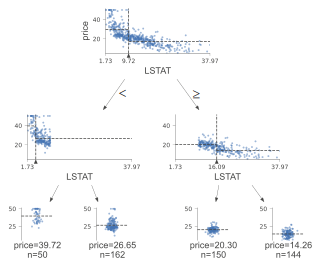

In [4]:
t = DecisionTreeRegressor(max_features=1, max_depth=2, random_state=999)#, min_samples_leaf=80)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

In [5]:
df_boston = df_boston.sample(len(df_boston), replace=True)
# X, y = df_boston.drop('y', axis=1), df['y']
X, y = df_boston[['LSTAT']], df_boston['y']

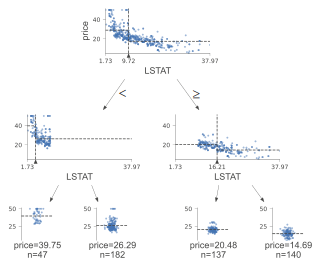

In [7]:
t = DecisionTreeRegressor(max_features=1, max_depth=2, random_state=999)#, min_samples_leaf=80)
# t = DecisionTreeRegressor(max_features=1.0, min_samples_leaf=80)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

## max features to decorrelate

In [35]:
df_boston = boston()
X, y = df_boston.drop('y', axis=1), df_boston['y']
features = X.columns
X.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03


In [36]:
X.shape

(506, 13)

Base tree using all features, not bootstrapping.

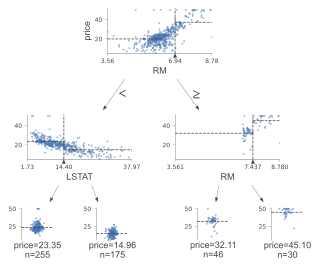

In [37]:
t = DecisionTreeRegressor(max_features=1.0, max_depth=2)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

Now run max_features=5 to see different tree 

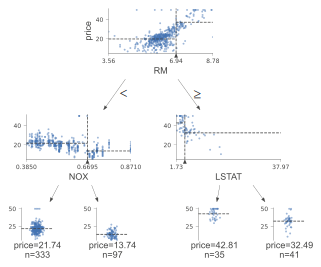

In [38]:
t = DecisionTreeRegressor(max_features=8, max_depth=2)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

Now run again to see different tree 

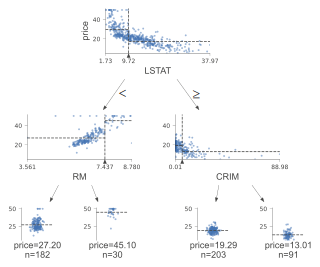

In [39]:
t = DecisionTreeRegressor(max_features=8, max_depth=2)
t.fit(X,y)
dtreeviz(t,
       X,
       y,
       target_name='price',
       feature_names=features)

## Error vs num trees

In [13]:
def sim_ntrees(X_train, X_test, y_train, y_test,
                max_features = 'auto',
                min_samples_leaf=1,      # lowest bias but increases variance
                ntrials = 5,
              tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50]):

    all_test_scores = np.zeros(shape=(ntrials,len(tree_sizes)))
    for i in range(ntrials):
        print(f" {i}", end='')
        test_scores = []
        for j,n_estimators in enumerate(tree_sizes):
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=True,
                                      n_jobs=-1)
            rf.fit(X_train, y_train)
            s = mean_absolute_error(y_test, rf.predict(X_test))
    #         s = rf.score(X_test, y_test)
            test_scores.append(s)

        all_test_scores[i] = test_scores
        avg = np.mean(test_scores)
        
    return all_test_scores, tree_sizes

### Fixed train/test, effect of num trees

In [14]:
df_rent = pd.read_csv("data/rent-ideal.csv")
X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
y = df_rent['price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

#max_features = X_train.shape[1]
max_features = 1
# max_features = 1
ntrials = 5

all_test_scores, tree_sizes = sim_ntrees(X_train, X_test, y_train, y_test, max_features=max_features)
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
test_variances

 0 1 2 3 4

array([2.72788841, 3.74158017, 2.22663499, 2.53971889, 0.69884604,
       0.86371642, 1.7584443 , 1.16643531, 0.91323562, 0.86154528,
       0.74097369, 0.37364316])

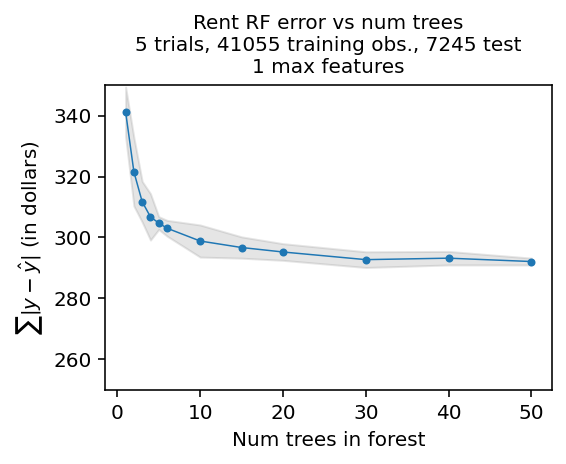

In [15]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, test_means, lw=.75, marker='.', label="test set $\sum |y - \hat{y}|$")

plt.fill_between(tree_sizes, 
                 test_means - test_variances*3,
                 test_means + test_variances*3,
                 color='gray', alpha=0.2)

# ax2 = ax.twinx()
# b = ax2.plot(tree_sizes, test_variances*3, lw=1, label="test set MAE $3\sigma$", c='orange')
# ax2.yaxis.label.set_color('orange')
# #ax2.set_ylabel("Test $\sigma$")
# ax2.tick_params(axis='y', colors='orange')
# ax2.set_ylim(-0.002,15.0)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("$\sum |y - \hat{y}|$ (in dollars)")
ax.set_ylim(250,350)
# lines = a+b
# labels = [l.get_label() for l in lines]
# ax.legend(lines,labels,loc='upper right')

#ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==X_train.shape[1]:
    ax.set_title(f"Rent bagged forest error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features", fontsize=10)
else:
    ax.set_title(f"Rent RF error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features", fontsize=10)

#### Pick num trees

In [16]:
df_rent = pd.read_csv("data/rent-ideal.csv")
X = df_rent[['bedrooms','bathrooms','latitude','longitude']]
y = df_rent['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=20,
                               min_samples_leaf=1,
                               max_features=X.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8547038692739714, 289.52959957117673)

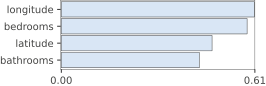

In [17]:
I = importances(rf, X_test, y_test)
plot_importances(I)

#### Select max features

In [18]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=20,
                               min_samples_leaf=1,
                               max_features=X.shape[1]-3,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8581025152261835, 288.7747444352401)

Can crank num trees up if you want

In [19]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=100,
                               min_samples_leaf=1,
                               max_features=X.shape[1]-3,
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.8609493615729139, 284.80143759424334)

## Bulldozer

In [20]:
def bulldozer(basefeatures = ['SalesID',
                    'MachineID', 'ModelID',
                    'datasource', 'YearMade',
                    # some missing values but use anyway:
                    'auctioneerID', 'MachineHoursCurrentMeter']):
    df_bull = pd.read_feather("data/bulldozer-train.feather") # these are sorted by date

    df_bull = df_bull.fillna(0) # flip missing numeric values to zeros

    ntest = 15_000
    df_bull_test = df_bull.iloc[-ntest:] # take only last 100,000 records
    df_bull_train = df_bull.iloc[-(100_000+ntest):-ntest] # train only last 100,000 records

    X_train, y_train = df_bull_train[basefeatures], df_bull_train['SalePrice']
    X_test, y_test = df_bull_test[basefeatures], df_bull_test['SalePrice']

    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = bulldozer()

#max_features = len(X_train.columns)
max_features = len(X_train.columns)-1
min_samples_leaf = 1
ntrials = 5

all_test_scores, tree_sizes = sim_ntrees(X_train, X_test, y_train, y_test, ntrials=ntrials,
                                         max_features=max_features,
                                         min_samples_leaf=min_samples_leaf,
                                        tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50,100])
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
test_variances

 0 1 2 3 4

array([ 86.97943   , 425.42593504, 121.30550704, 175.04605161,
        65.59592633, 107.09114209,  95.9241484 ,  92.25592482,
        67.9713446 ,  66.96702364,   6.91350717,  43.43889597,
        29.89699936])

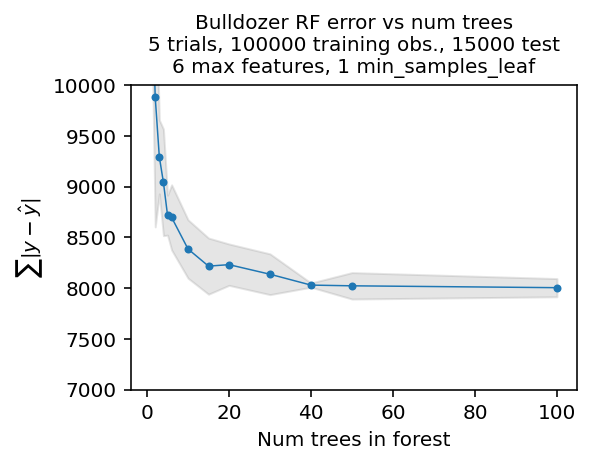

In [22]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, test_means, lw=.75, marker='.', label="test set $\sum |y - \hat{y}|$")

plt.fill_between(tree_sizes, 
                 test_means - test_variances*3,
                 test_means + test_variances*3,
                 color='gray', alpha=0.2)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("$\sum |y - \hat{y}|$")
ax.set_ylim(7000,10_000)
#ax.legend(loc='upper right')

#ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==len(X_train.columns):
    ax.set_title(f"Bulldozer bagged forest error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)
else:
    ax.set_title(f"Bulldozer RF error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)

#### Tuning; find num trees first

In [23]:
X_train, X_test, y_train, y_test = bulldozer()

scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=30,
                               min_samples_leaf=1,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.766559199732385, 7792.221473777778)

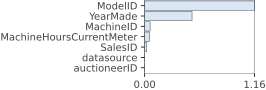

In [24]:
I = importances(rf, X_test, y_test)
plot_importances(I)

#### Set min_samples_leaf

(max_features is best at p).

Slight improvement with `min_samples_leaf`=2

In [25]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=30,
                               min_samples_leaf=2,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.7698141766688131, 7686.497347678269)

Now crank num trees

In [26]:
scores = []
maes = []
for i in range(5):
    print(i, end=' ')
    rf = RandomForestRegressor(n_estimators=150,
                               min_samples_leaf=2,
                               max_features=X_train.shape[1],
                               n_jobs=-1)
    rf.fit(X_train, y_train)
    mae = mean_absolute_error(y_test, rf.predict(X_test))
    maes.append(mae)
    s = rf.score(X_test, y_test)
    scores.append(s)
np.mean(scores), np.mean(maes)

0 1 2 3 4 

(0.7748262751139381, 7594.177050080592)

## Synthetic quadratic data

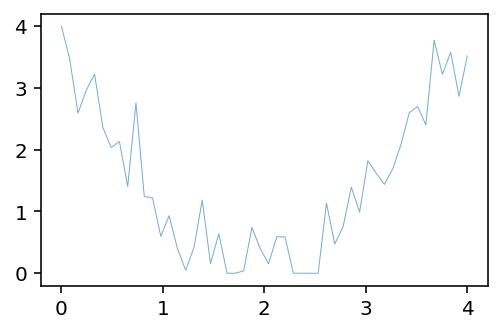

In [20]:
def quad_data(n = 50):
    X = np.linspace(0,4,num=n).reshape(n,1)
    y = (X-2)**2 + np.random.normal(0,.4,n).reshape(n,1)
    y = np.clip(y,0,4) # clip a little bit so that the animation is stable below
    return X,y

X,y = quad_data()
fig,ax = plt.subplots(1,1,figsize=(4,2.5))
# ax.scatter(X,y,s=20,c='#ABD9E9',edgecolors=GREY,lw=.35)
ax.plot(X,y,c='#73ADD2',lw=.5)
plt.show()

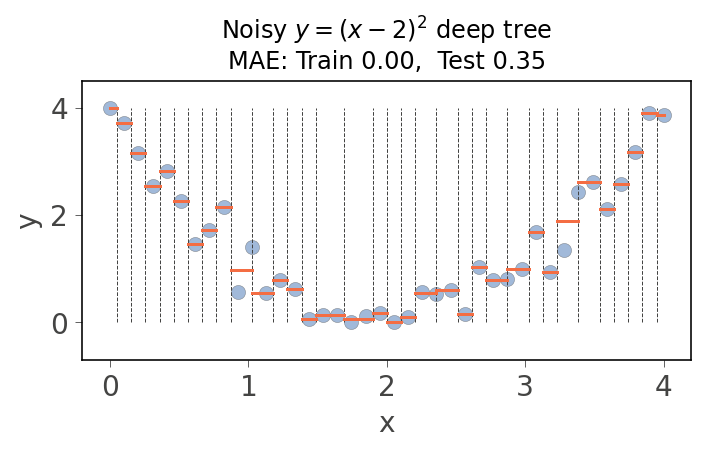

In [21]:
def plot_sample_regions(n=40):
    X,y = quad_data(n=n)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
    t = DecisionTreeRegressor()
    t.fit(X_train,y_train)

    fig, ax = plt.subplots(1,1, figsize=(5,3.3))
    rtreeviz_univar(t, X, y, 'x', 'y', ax=ax, show={'splits'},
                    markersize=50, mean_linewidth=1.5)
    y_pred_train = t.predict(X_train)
    y_pred_test = t.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    ax.set_title(f"Noisy $y=(x-2)^2$ deep tree\nMAE: Train {mae_train:.2f},  Test {mae_test:.2f}")
    ax.set_ylim(-.7,4.5)
    plt.tight_layout()

plot_sample_regions()

It's off by like 0.46 MAE, which is a lot because that's a good portion of the overall y range of 0..4.

### Animate different partitionings

In [24]:
import pltvid
camera = pltvid.Capture()

for i in range(5):
    plot_sample_regions()
    camera.snap()
    
camera.save("/Users/parrt/Desktop/syn.gif", duration=750)

### Animate aggregation of multiple samples

In [1251]:
camera = pltvid.Capture(dpi=300)

n=50
for nsamples in [1,2,3]+[*range(4,20+1,2)]+[100]:
    fig,ax = plt.subplots(1,1,figsize=(3.8,2.5))
    y_avg = np.zeros(shape=(n,1))
    for i in range(nsamples):
        X,y = quad_data(n=n)
        y_avg += y
        ax.plot(X,y,c='#73ADD2',lw=.5,alpha=4/nsamples)

    y_avg /= nsamples
    ax.plot(X,y_avg,c='#D73028',lw=1)
    ax.set_title(f"{nsamples} regression tree ensemble")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y=(x-2)^2$")
    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    plt.tight_layout()
    if nsamples>=100:
        camera.snap(5)
    else:
        camera.snap()
    
camera.save("/Users/parrt/Desktop/syn-aggr.gif", duration=500)

### Check variance of predictions from decision trees

Let's train multiple decision trees to multiple i.i.d. samples from the quadratic noisy data set and then look at the variance between tree model predictions.

In [1263]:
def ensemble(ntrees,       # more trees => tighter variance
             x,            # which test record
             ntrials=100,  # more trials => higher resolution
             n=100):
    y_preds = []
    for trial in range(ntrials):
        # Get ensemble of decision trees
        trees = []
        for i in range(ntrees):
            X,y = quad_data(n=n) # train with noisy data
            y = y.reshape(n)
            t = DecisionTreeRegressor()
            t.fit(X,y)
            trees.append(t)

        # get ensemble prediction via average
        y_pred = np.mean([t.predict(x)[0] for t in trees])
        y_preds.append(y_pred)
    return np.array(y_preds)

def plot_pred_histo(y_preds, ntrees, ntrials, show_mean=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3.8,2.2))
    r = max(y_preds) - min(y_preds)
    nbins = int(r/.05)
    # print(f"range {r}, nbins={nbins}")
    n, bins, regions = ax.hist(y_preds, color='#FEE08F', bins=nbins)
    for rect in regions:
        rect.set_linewidth(.5)
        rect.set_edgecolor('grey')
        
    ax.plot([1.0,1.0],[0,80],'--',c=GREY,lw=.7)
    if show_mean:
        ax.scatter([1.0],[2],s=18,c='#D73028',zorder=3) # red dot

    ax.spines['top'].set_visible(False)  # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.set_xlabel("Avg prediction for $y=(x-2)^2=1.0$ at $x=3$")
    ax.set_xlim(.3,1.7)
    ax.set_ylim(0, 80)
    ax.set_yticks([0,20,40,60,80])
    ax.set_title(f"Distr. of ensemble mean ({ntrials} trials)\n"+\
                 f"$\mu = {np.mean(y_preds):.3f}$, $\sigma = {np.var(y_preds):.3f}$",
                 fontsize=11)

avg 0.9893478266346782 var 0.012779995842049221


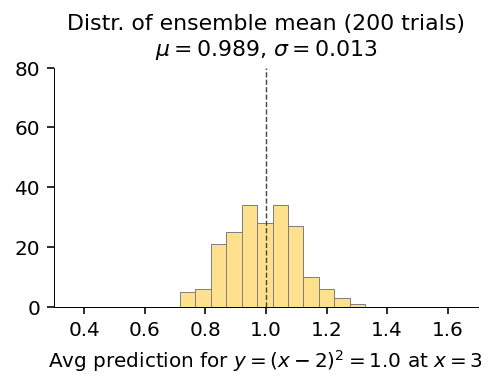

In [1264]:
ntrials = 200
# pick, say, x=3 as test record
x = np.array([3]).reshape(1,1)
y_preds = ensemble(ntrees=10, x=x, ntrials=ntrials)
print("avg", np.mean(y_preds), 'var', np.var(y_preds))

plot_pred_histo(y_preds, ntrees=10, ntrials=ntrials)

In [1266]:
camera = pltvid.Capture(dpi=300)

n = 100
ntrials = 200
x = np.array([3]).reshape(1,1)  # test record
for ntrees in range(3,30,2):
    y_preds = ensemble(ntrees=ntrees, x=x, ntrials=ntrials, n=n)
    plot_pred_histo(y_preds, ntrees=ntrees, ntrials=ntrials)
    plt.tight_layout()
    camera.snap()
    
camera.save("/Users/parrt/Desktop/syn-var.gif", duration=500)

In [1265]:
# animate both ensemble and avg pred histo
camera = pltvid.Capture(dpi=300)

n = 100
ntrials = 200
x = np.array([3]).reshape(1,1)  # test record
for ntrees in [*range(2,40,3)]+[100]:
    fig, axes = plt.subplots(1, 2, figsize=(7.4,2.2))
    # plot ensemble predictions on left
    y_avg = np.zeros(shape=(n,1))
    y3_avg = 0.0
    for i in range(ntrees):
        X,y = quad_data(n=n)
        x3_idx = np.where(np.isclose(X,x[0,0],atol=.02))
        y3_avg += y[x3_idx]
        y_avg += y
        axes[0].plot(X,y,c='#73ADD2',lw=.5,alpha=4/ntrees)

    y_avg /= ntrees
    y3_avg /= ntrees

    # rectangle showing x=3
#     rect = patches.Rectangle(xy=(x[0,0]-.03,0), width=.06, height=4,
#                              linewidth=.1,edgecolor=GREY,
# #                              facecolor='#E0F4F7',
#                              facecolor='none',
#                              alpha=1.0)
#     axes[0].add_patch(rect)
    axes[0].set_yticks([0,1,2,3,4])

    axes[0].plot(X,y_avg,c='#D73028',lw=1,alpha=.7) # red dot
    axes[0].scatter([X[x3_idx]],[y3_avg],s=15,c='#D73028') # red dot
    axes[0].set_title(f"{ntrees} tree ensemble; 1 trial",
                      fontsize=11)
    axes[0].set_xlabel("$x$")
    axes[0].set_ylabel("$y=(x-2)^2$")

    y_preds = ensemble(ntrees=ntrees, x=x, ntrials=ntrials)
    plot_pred_histo(y_preds, ntrees=ntrees, ntrials=ntrials,
                    show_mean=True, ax=axes[1])
    plt.tight_layout()
    if ntrees>=100:
        camera.snap(5)
    else:
        camera.snap()    
camera.save("/Users/parrt/Desktop/syn-var-combo.gif", duration=500)

## Wine data partitioning animation; overfitting

In [25]:
wine = load_wine()
X = wine.data[:,[12,6]] # ['proline','flavanoid']
y = wine.target

X.shape

(178, 2)

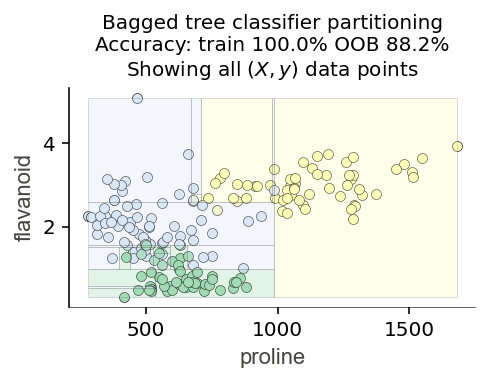

In [26]:
# bootstrap a subsample to simulate different identically-distributed datasets

def plot_bagged_tree(X,y):
    n = len(y)
    idx = np.random.randint(0,n,size=n) 
    X_train = X[idx]
    y_train = y[idx]
    # get OOB samples
    mask = np.ones(n, dtype=bool)
    mask[idx] = False
    X_test = X[mask]
    y_test = y[mask]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    accur_train = dt.score(X_train, y_train)
    accur_oob = dt.score(X_test, y_test)

    figsize = (3.5,2.8)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ct = ctreeviz_bivar(dt, X, y, # plot original points not bootstrap
                         feature_names = ['proline','flavanoid'], 
                         target_name='wine',
                         show={'splits'},
                         colors={'scatter_edge': 'black'},
                        fontsize=11,
                        ax=ax
                       )
    ax.set_title(f"Bagged tree classifier partitioning\nAccuracy: train {accur_train*100:.1f}% OOB {accur_oob*100:.1f}%\nShowing all ($X,y$) data points",
                fontsize=10)
    plt.tight_layout()
    
plot_bagged_tree(X,y)

In [33]:
n = len(y)
idx = np.random.randint(0,n,size=n) 
X_train = X[idx]
y_train = y[idx]

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
t = dtreeviz(dt, X_train, y_train,
             target_name='wine',
             feature_names = ['proline','flavanoid'])
t.save("/Users/parrt/Desktop/wine-tree-d2-2.svg")

In [600]:
camera = pltvid.Capture()

max_trees=20
for ntrees in range(1,max_trees+1,2):
    rf = RandomForestClassifier(n_estimators=ntrees, n_jobs=-1,
                                max_features=2) # full decision tree
    rf.fit(X, y)
    fig, ax = plt.subplots(1, 1, figsize=(3, 2.6))
    showreg = True if ntrees <= 7 else False
    ctreeviz_bivar_fusion(rf.estimators_, X, y,
                          feature_names=['proline', 'flavanoid'],
                          target_name="wine",
                          show_region_edges=showreg,
                          alpha=.8/ntrees,
                          fontsize=10,
                          ax=ax)
    ax.set_title(f"Ensemble of {ntrees} bagged trees", fontsize=10)
    plt.tight_layout()
    if ntrees>=max_trees-1:
        camera.snap(5)
    else:
        camera.snap()

camera.save("/Users/parrt/Desktop/wine-fusion.gif", duration=500)

In [574]:
rf = RandomForestClassifier(n_estimators=20, oob_score=True, max_features=2)
rf.fit(X, y)
print(f"RF OOB accuracy {rf.oob_score_*100:.2f}%")

RF OOB accuracy 85.39%


## Smiley synthetic data set

In [481]:
def smiley(n = 1000):
    # mouth
    x1 = np.random.normal(1.0,.2,n).reshape(-1,1)
    x2 = np.random.normal(0.4,.25,n).reshape(-1,1)
    cl = np.full(shape=(n,1), fill_value=0, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = d
    
    # left eye
    x1 = np.random.normal(.7,.2,n).reshape(-1,1)
#     x2 = np.random.normal(0.8,.1,n).reshape(-1,1)
    x2 = x1 + .3 + np.random.normal(0,.15,n).reshape(-1,1)
    cl = np.full(shape=(n,1), fill_value=1, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = np.vstack([data, d])

    # right eye
    x1 = np.random.normal(1.3,.2,n).reshape(-1,1)
    x2 = np.random.normal(0.8,.1,n).reshape(-1,1)
    x2 = x1 - .5 + .3 + np.random.normal(0,.15,n).reshape(-1,1)
    cl = np.full(shape=(n,1), fill_value=2, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = np.vstack([data, d])

    # face outline
    noise = np.random.normal(0,.1,n).reshape(-1,1)
    x1 = np.linspace(0,2,n).reshape(-1,1)
    x2 = (x1-1)**2 + noise
    cl = np.full(shape=(n,1), fill_value=3, dtype=int)
    d = np.hstack([x1,x2,cl])
    data = np.vstack([data, d])

    df = pd.DataFrame(data, columns=['x1','x2','class'])
    return df

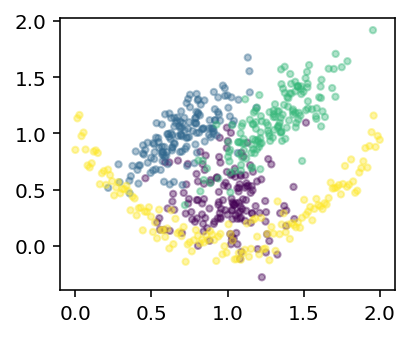

In [482]:
df = smiley(n=150)
X = df[['x1','x2']].values
y = df['class'].values
plt.figure(figsize=(3,2.5))
plt.scatter(df.x1,df.x2,s=10,alpha=.4,c=df['class'])
plt.show()

### Fuse regions

/Users/parrt/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/parrt/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


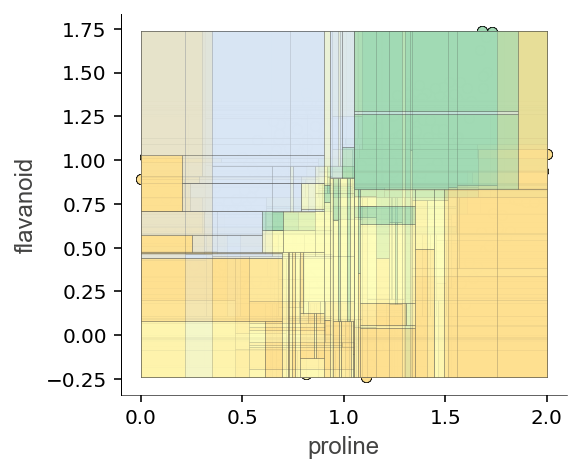

In [551]:
df = smiley(n=100)
X = df[['x1','x2']].values
y = df['class'].values
rf = RandomForestClassifier(n_estimators=10, oob_score=True)
rf.fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
ctreeviz_bivar_fusion(rf.estimators_, X, y,
                      feature_names=['proline', 'flavanoid'], target_name="wine",
#                       show_region_edges=False,
                      alpha=.5,
                      ax=ax)

In [487]:
camera = pltvid.Capture(dpi=300)
for i in range(7):
    plot_bagged_tree(X,y)
    camera.snap()
    
camera.save("/Users/parrt/Desktop/smiley-bag.gif", duration=1000)

In [520]:
df = smiley(n=100)
X = df[['x1','x2']].values
y = df['class'].values
rf = RandomForestClassifier(n_estimators=200, oob_score=True, max_features=2)
rf.fit(X, y)
print(f"RF OOB accuracy {rf.oob_score_*100:.2f}%")


RF OOB accuracy 85.50%
